In [388]:
# paquetes necesarios
import pandas as pd
import random
import copy

In [389]:
# lectura de archivos, Paridad.csv
pdf = pd.read_csv("Paridad.csv")
entradas = list(pdf[["A","B","C"]].itertuples(index=False, name=None))
salidas = pdf["S"].tolist()

In [390]:
# definición de los operadores lógicos 
class Booleanos:
    def __init__(self, operador, hijos=None):
        self.operador = operador
        self.hijos = hijos or []

    def eval(self, v):
        # terminal
        if not self.hijos:
            if self.operador in v:
                return v[self.operador]
            if self.operador in ("0", "1"):
                return int(self.operador)
            raise ValueError(f"Terminal desconocido: {self.operador}")
        # no terminal
        valores = [h.eval(v) for h in self.hijos]
        if self.operador == "AND":
            return valores[0] & valores[1]
        if self.operador == "OR":
            return valores[0] | valores[1]
        if self.operador == "NOT":
            return 1 - valores[0]
        if self.operador == "XOR":
            return valores[0] ^ valores[1]
        raise ValueError(f"Operador desconocido: {self.operador}")

    def lectura(self):
        # terminal
        if not self.hijos:
            return self.operador
        # NOT
        if self.operador == "NOT":
            return f"NOT({self.hijos[0].lectura()})"
        # AND, OR, XOR
        izq = self.hijos[0].lectura()
        der = self.hijos[1].lectura()
        return f"({izq} {self.operador} {der})"

In [391]:
# conjunto de funciones
F1 = [("AND",2), ("OR",2), ("NOT",1)]
F2 = [("AND",2), ("OR",2), ("NOT",1), ("XOR",2)]
# conjunto terminal
T = ["A", "B", "C", "0", "1"]

In [392]:
# definición de la estructura del árbol
def gen_arbol(max_p, funcs):
    def crecer(p):
        if p >= max_p or (p > 0 and random.random() < 0.3):
            return Booleanos(random.choice(T))
        n, aridad = random.choice(funcs)
        return Booleanos(n, [crecer(p+1) for _ in range(aridad)])
    return crecer(0)

In [393]:
# definición del conjunto de vértices hijos 
# de un descendencia(v), con v cualquier vértice
def descendencia(v):
    sal = [(None, None, v)]
    for idx, hijo in enumerate(v.hijos):
        for padre, i, nodo in descendencia(hijo):
            a = v if padre is None else padre
            b = idx if padre is None else i
            sal.append((a, b, nodo))
    return sal

In [394]:
# definición del punto de cruza 
def cruza(padre1, padre2):
    t1 = copy.deepcopy(padre1)
    t2 = copy.deepcopy(padre2)
    v1 = descendencia(t1)
    v2 = descendencia(t2)
    p1, i1, sub1 = random.choice(v1)
    p2, i2, sub2 = random.choice(v2)
    if p1 is None:
        hijo1 = sub2
    else:
        p1.hijos[i1] = sub2
        hijo1 = t1
    if p2 is None:
        hijo2 = sub1
    else:
        p2.hijos[i2] = sub1
        hijo2 = t2
    return hijo1, hijo2

In [395]:
# definición de mutación
def muta(arbol, funcs, max_p):
    t = copy.deepcopy(arbol)
    hojas = descendencia(t)
    padre, idx, _ = random.choice(hojas)
    nuevo = gen_arbol(max_p, funcs)
    if padre is None:
        return nuevo
    padre.hijos[idx] = nuevo
    return t

In [396]:
# definición de aptitud
def fit(ind, entradas, salidas):
    conta = 0
    for ent, sal in zip(entradas, salidas):
        v = {"A":ent[0], "B":ent[1], "C":ent[2]}
        if ind.eval(v) == sal:
            conta = conta + 1
    return conta

In [397]:
# parámetros
k = 3               # torneo
ngen = 100           # número de generaciones
pob_size = 100      # tamaño de la población
prob_cruza = 0.8    # probabilidad de cruza
prob_muta = 0.1     # probabilidad de mutación
max_p = 4           # máxima profundidad

In [398]:
# torneo de k individuos
def torneo(pob, k=3):
    aspirantes = random.sample(pob, k)
    return max(aspirantes, key=lambda ind: ind.fit)

In [399]:
# programación genética
def PG(funcs, ngen, pob_size, prob_cruza, prob_muta, max_p):
    pob = [gen_arbol(max_p, funcs) for _ in range(pob_size)]
    for ind in pob:
        ind.fit = fit(ind, entradas, salidas)
    top = max(pob, key=lambda ind: ind.fit)
    no_mejora = 0
    
    for gen in range(1, ngen+1):
        nueva = []
        while len(nueva) < pob_size:
            p1 = torneo(pob)
            p2 = torneo(pob)
            if random.random() < prob_cruza:
                c1, c2 = cruza(p1, p2)
            else:
                c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)
            if random.random() < prob_muta:
                c1 = muta(c1, funcs, max_p)
            if random.random() < prob_muta:
                c2 = muta(c2, funcs, max_p)
            c1.fit = fit(c1, entradas, salidas)
            c2.fit = fit(c2, entradas, salidas)
            nueva.extend([c1, c2])
        pob = nueva
        mejor = max(pob, key=lambda ind: ind.fit)
        print(f"Gen {gen:02d}: mejor fitness = {mejor.fit}/{len(entradas)}")
        
        # condición de paro
        if mejor.fit > top.fit:
            top, no_mejora = mejor, 0
        else:
            no_mejora = no_mejora + 1

        if mejor.fit == len(entradas):
            print(f"Aptitud alcanzada en {gen} generaciones")
            break

        if no_mejora >= 25:
            print(f"No mejora en {no_mejora} generaciones")
            break
    return mejor, mejor.fit / len(entradas)

In [400]:
if __name__ == "__main__":
    n_exps = 10
    f1_salida = []
    f2_salida = []

    print ("=====F1=====")
    for exps in range(1, n_exps + 1):
        print(f"--Experimento \n {exps}/{n_exps}--")
        best1, acc1 = PG(F1, ngen, pob_size, prob_cruza, prob_muta, max_p)
        f1_salida.append(acc1)
        print("Mejor ecuación:", best1.lectura())
        print(f" Exactitud: {acc1*100:.1f}%\n")

    print ("=====F2=====")
    for exps in range(1, n_exps + 1):
        print(f"--Experimento \n {exps}/{n_exps}--")
        best2, acc2 = PG(F2, ngen, pob_size, prob_cruza, prob_muta, max_p)
        f2_salida.append(acc2)
        print("Mejor ecuación:", best2.lectura())
        print(f" Exactitud: {acc2*100:.1f}%\n")

    print(f"Réplica {exps+1}/{n_exps} - F1: {acc1*100:.1f}% | F2: {acc2*100:.1f}%")

=====F1=====
--Experimento 
 1/10--
Gen 01: mejor fitness = 5/8
Gen 02: mejor fitness = 5/8
Gen 03: mejor fitness = 5/8
Gen 04: mejor fitness = 5/8
Gen 05: mejor fitness = 5/8
Gen 06: mejor fitness = 5/8
Gen 07: mejor fitness = 5/8
Gen 08: mejor fitness = 5/8
Gen 09: mejor fitness = 5/8
Gen 10: mejor fitness = 5/8
Gen 11: mejor fitness = 5/8
Gen 12: mejor fitness = 5/8
Gen 13: mejor fitness = 5/8
Gen 14: mejor fitness = 5/8
Gen 15: mejor fitness = 5/8
Gen 16: mejor fitness = 5/8
Gen 17: mejor fitness = 5/8
Gen 18: mejor fitness = 5/8
Gen 19: mejor fitness = 5/8
Gen 20: mejor fitness = 5/8
Gen 21: mejor fitness = 5/8
Gen 22: mejor fitness = 5/8
Gen 23: mejor fitness = 5/8
Gen 24: mejor fitness = 5/8
Gen 25: mejor fitness = 5/8
No mejora en 25 generaciones
Mejor ecuación: NOT((((1 AND A) AND NOT((C OR B))) OR NOT(NOT((NOT(1) AND (0 OR ((1 AND A) OR (0 OR NOT(((NOT(((NOT((1 AND NOT(B))) OR (NOT(NOT((NOT(NOT(0)) AND (0 OR ((1 AND A) OR (0 OR NOT(((NOT((1 AND NOT(B))) OR 1) AND NOT((1 AND N

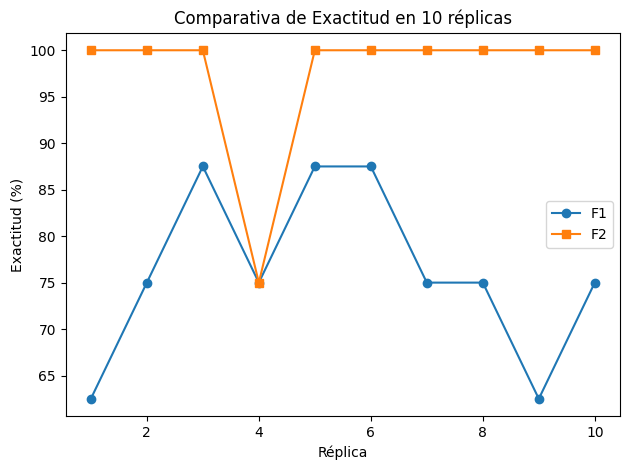

In [402]:
import matplotlib.pyplot as plt
# gráfica de resultados
runs = list(range(1, n_exps+1))
plt.figure()
plt.plot(runs, [x*100 for x in f1_salida], marker='o', label='F1')
plt.plot(runs, [x*100 for x in f2_salida], marker='s', label='F2')
plt.xlabel('Réplica')
plt.ylabel('Exactitud (%)')
plt.title('Comparativa de Exactitud en 10 réplicas')
plt.legend()
plt.tight_layout()
plt.show()